In [49]:
# Librairies classiques
import pandas as pd
import numpy as np
import os

# Pour le NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Pour sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Pour keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Attention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [50]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hamou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [51]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


# Étape 1 : Chargement et exploration des données

In [52]:
df = pd.read_csv("imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [53]:
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [54]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [55]:
print(df['sentiment'].unique())

['positive' 'negative']


In [56]:
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


# Étape 2 : Nettoyage et prétraitement du texte

In [57]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Téléchargements nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Pour les lemmes multilingues

# Initialisation
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fonction modifiée avec lemmatisation
def clean_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word not in string.punctuation
    ]
    return " ".join(tokens)

# Application au dataset
df['cleaned_review'] = df['review'].apply(clean_text)
print(df['cleaned_review'].head())



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hamou\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hamou\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    one reviewer mentioned watching 1 oz episode '...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically 's family little boy jake think 's z...
4    petter mattei 's `` love time money '' visuall...
Name: cleaned_review, dtype: object


# Étape 3 : Encodage des labels

In [58]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
print(df[['sentiment', 'sentiment_encoded']].head())


  sentiment  sentiment_encoded
0  positive                  1
1  positive                  1
2  positive                  1
3  negative                  0
4  positive                  1


# Étape 4 : Séparation des données en train/test

In [59]:
from sklearn.model_selection import train_test_split

X = df['cleaned_review']
y = df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Étape 5 : Tokenization + padding

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [61]:
print("Exemple séquence padding:", X_train_pad[0])

# --- Fin de la préparation ---
print(f"Train shape: {X_train_pad.shape}, Test shape: {X_test_pad.shape}")
print(f"Train labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

Exemple séquence padding: [   8 2709 3480 1527   67  119  121  114   67  964 1109    6  984    3
  877  284    5  379  157   15   41   41  485 3110   95 1245   94 4048
  120  587  259 4942 2120  192  517  252 2770 1103 3392   62  351  918
 1033  757 1099  163 2710  290  523    1    1  178 3339  876 1152   15
  129    7  110 1224  890 4574  127  267 1520    7 2344    2  109  767
 2646  694   79   64   82   38    6  370  130  211 1343 1452 4386  426
    4 3183 1655 2284  227  320 2422 2012  483  418 3405  354   77  116
  132 3597]
Train shape: (40000, 100), Test shape: (10000, 100)
Train labels shape: (40000,), Test labels shape: (10000,)


# Modèle LSTM

# 📌 Comparaison des pertes Keras

## ✅ Tableau récapitulatif

| Perte                           | Type de problème       | Format des labels              | Dernière couche recommandée           |
| ------------------------------- | ----------------------- | ------------------------------ | ------------------------------------- |
| `binary_crossentropy`           | Binaire (2 classes)     | 0 ou 1                         | `Dense(1, activation='sigmoid')`      |
| `categorical_crossentropy(notgood)`      | Multi-classes (>2)      | One-hot encoding (ex: [0,1,0]) | `Dense(num_classes, activation='softmax')` |
| `sparse_categorical_crossentropy` | Multi-classes (>2)    | Entiers (ex: 0, 1, 2)          | `Dense(num_classes, activation='softmax')` |

---

## ✅ Explications courtes

- **binary_crossentropy**
  - ✔️ Pour **2 classes** (exemple : positif / négatif)
  - ✔️ Labels attendus : 0 ou 1
  - ✔️ Dernière couche : `Dense(1, activation='sigmoid')`

---

- **categorical_crossentropy** 
  - ✔️ Pour **multi-classes** (> 2 classes)
  - ✔️ Labels attendus : **one-hot encoded** (exemple : [0,1,0])
  - ✔️ Dernière couche : `Dense(num_classes, activation='softmax')`

---

- **sparse_categorical_crossentropy**
  - ✔️ Pour **multi-classes** (> 2 classes)
  - ✔️ Labels attendus : **entiers** (exemple : 0, 1, 2)
  - ✔️ Pas besoin de one-hot encoding
  - ✔️ Dernière couche : `Dense(num_classes, activation='softmax')`

---

## ✅ Résumé ultra-court

> ⭐️ **Binary** = 2 classes.  
> ⭐️ **Categorical** = one-hot.  
> ⭐️ **Sparse categorical** = entiers.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Paramètres
vocab_size = 5000  # comme dans le tokenizer
embedding_dim = 128 #Convertit chaque mot (indice) en un vecteur dense de taille 128.
max_len = 100 # longueur fixe des séquences en entrée (padding/troncature).

# Construction du modèle
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),# un neuron de 640 000 = 5000 * 128p
    LSTM(128, return_sequences=True), #Convertit chaque mot (indice) en un vecteur dense de taille 128.
    Dropout(0.2), #Régularisation pour réduire le surapprentissage en "éteignant" aléatoirement 20% des neurones pendant l’entraînement.
    LSTM(64), #Deuxième LSTM (64 unités), Traite la séquence produite par la couche précédente.
              # <--- cette couche retourne un vecteur de taille 64
    Dropout(0.2), #Nouvelle régularisation.
    Dense(1, activation='sigmoid')  # classification binaire
])

#Compile le modèle pour le préparer à l’entraînement.
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#Affiche un résumé détaillé du modèle
model_lstm.summary()

# Callbacks
#Arrête l’entraînement automatiquement si la perte de validation (val_loss) ne s’améliore pas pendant 3 epochs consécutives.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#Réduit le taux d’apprentissage (learning rate) par un facteur 0.5 si la perte de validation (val_loss) ne s’améliore pas pendant 2 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Entraînement
history = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)


c:\Users\hamou\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 142ms/step - accuracy: 0.7799 - loss: 0.4436 - val_accuracy: 0.8783 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 97s 195ms/step - accuracy: 0.9045 - loss: 0.2423 - val_accuracy: 0.8727 - val_loss: 0.3018 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 113ms/step - accuracy: 0.9262 - loss: 0.1938 - val_accuracy: 0.8751 - val_loss: 0.3134 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 114ms/step - accuracy: 0.9556 - loss: 0.1283 - val_accuracy: 0.8689 - val_loss: 0.3751 - learning_rate: 5.0000e-04


# Évaluation complète du modèle LSTM : matrice de confusion, métriques de performance et courbe ROC

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Matrice de Confusion :
[[4334  627]
 [ 565 4474]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



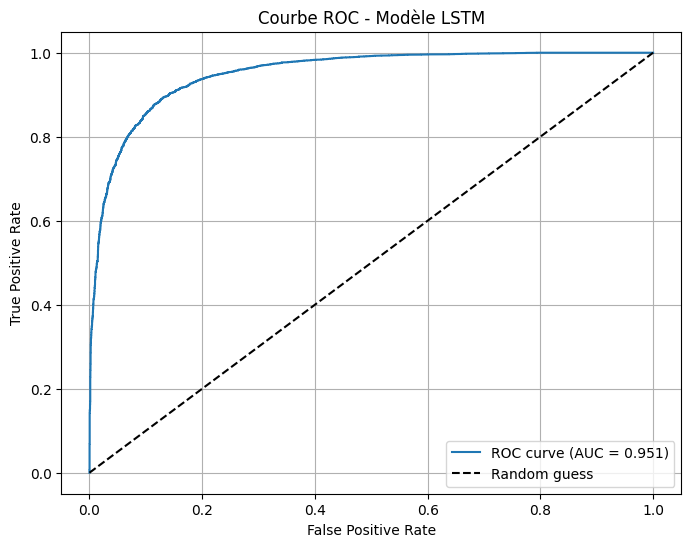

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Prédictions sur le jeu test (probabilités)
y_pred_prob = model_lstm.predict(X_test_pad)

# Seuil à 0.5 pour obtenir les classes prédites
y_pred = (y_pred_prob > 0.5).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de Confusion :")
print(cm)

# Rapport de classification (precision, recall, f1-score)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Calcul ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Modèle LSTM')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Axes
Axe des X (False Positive Rate - FPR) : Taux de faux positifs, c’est-à-dire la proportion de négatifs mal classés en positifs.

## Axe des Y (True Positive Rate - TPR) : Taux de vrais positifs, la proportion de positifs correctement détectés (aussi appelé sensibilité ou recall).

## Courbe ROC
La courbe montre le compromis entre TPR et FPR à différents seuils de classification.

Plus la courbe est proche du coin supérieur gauche (TPR=1, FPR=0), meilleur est le modèle.

## AUC (Area Under the Curve)
L’aire sous la courbe ROC est ici 0.950.

L’AUC mesure la capacité du modèle à distinguer entre classes positives et négatives.

Une AUC de 0.95 est excellente, cela signifie que ton modèle a 95% de chances de classer correctement un exemple positif par rapport à un négatif.

## La ligne pointillée
Elle correspond à un modèle aléatoire (AUC=0.5).

Ta courbe étant bien au-dessus, ton modèle est clairement performant.

# Test sur une phrase pas dans le dataset

In [64]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    cleaned = " ".join(tokens)
    return cleaned

# Exemple de nouvelle critique
# new_review = "This movie was amazing, I really enjoyed the story and the characters."
new_review = "This movie was boring."
# Nettoyage
cleaned_review = preprocess_text(new_review)

# Tokenization + séquence
seq = tokenizer.texts_to_sequences([cleaned_review])

# Padding
seq_pad = pad_sequences(seq, maxlen=max_len)

print("Séquence préparée :", seq_pad)


Séquence préparée : [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   3 255]]


In [65]:
# Prédiction (probabilité)
prob = model_lstm.predict(seq_pad)[0][0]

# Seuil 0.5 pour classer en 0 ou 1
pred_class = int(prob > 0.5)

# Décoder label
pred_label = le.inverse_transform([pred_class])[0]

print(f"Sentiment prédit : {pred_label} (probabilité={prob:.3f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sentiment prédit : negative (probabilité=0.173)
